In [1]:
## Import packages
import warnings
warnings.filterwarnings("ignore")
import numpy as np
from astropy.io import fits
from astropy.wcs import WCS
from astropy.convolution import convolve
from astropy.convolution import Gaussian2DKernel
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import pyregion

## WSRT missing short spacing correction method is taken from the one proposed by Braun and Walterbos, 1985

[A solution to the short spacing problem in radio interferometry](https://adsabs.harvard.edu/full/1985A%26A...143..307B)

In [2]:
# write the functions for bowl fitting (from Braun and Walterbos, 1985)
def sample_point(R, I, B, l, m, theta):
    sp  = R*np.cos((2*np.pi/B)*(l*np.cos(theta) + m*np.sin(theta))) + \
            I*np.sin((2*np.pi/B)*(l*np.cos(theta) + m*np.sin(theta)))
    return sp

def F(lm, A, \
      R1, R2, R3, R4, R5, R6, \
      I1, I2, I3, I4, I5, I6, \
     ):
    
    B = 18 #18m
    pixel_size = 22.852983*(4.848e-6) #radians
    th1, th2, th3, th4, th5, th6 = -np.pi/3, -np.pi/6, 0, np.pi/6, np.pi/3, np.pi/2 #radians
    l,m = lm
    l_r = l*pixel_size
    m_r = m*pixel_size

    f = A + sample_point(R1, I1, B, l_r, m_r, th1) + \
            sample_point(R2, I2, B, l_r, m_r, th2) + \
            sample_point(R3, I3, B, l_r, m_r, th3) + \
            sample_point(R4, I4, B, l_r, m_r, th4) + \
            sample_point(R5, I5, B, l_r, m_r, th5) + \
            sample_point(R6, I6, B, l_r, m_r, th6)
    return f

In [3]:
# Read the data and mask out the caompact and exteneded emission
'''Opening WSRT image and removing unnecessary header information'''
wsrthdu = fits.open('pers92-1950.fits',ignore_missing_end=True)
wsrthdu[0].data = wsrthdu[0].data[0,:,:]
wsrthdu[0].header.remove('CRPIX3')
wsrthdu[0].header.remove('CRVAL3')
wsrthdu[0].header.remove('CDELT3')
wsrthdu[0].header.remove('CRESL3')
wsrthdu[0].header.remove('CTYPE3')

# apply the masks
'''Creating a mask for masking out mini-halo from the reprojected WSRT image'''
r = pyregion.open("ctr.reg")
mask = r.get_mask(hdu = wsrthdu[0],shape=(1024,1024))
mask = np.logical_not(mask).astype(int)



## Smooth the mask a bit
lofarbeam_kern = Gaussian2DKernel(x_stddev=0.5, y_stddev=0.5)

# convolve the high-resolution mask with the with the lofar beam
smoothed_mask = convolve(np.logical_not(mask), lofarbeam_kern)
smoothed_mask = np.logical_not(smoothed_mask)


'''Create a mask from manually constructed region for excluding the central extended emission'''
r = pyregion.open("./bowlfitexclusion_wsrt2.reg")
mask_haloregion = r.get_mask(hdu = wsrthdu[0],shape=(1024,1024))
mask_haloregion = mask_haloregion.astype(int)

'''Create a mask for the grating ring'''
# r = pyregion.open("./grating_ring_wsrt.reg")
r = pyregion.open("./grating_ring_wsrt_smaller2.reg")
mask_gratingring = r.get_mask(hdu = wsrthdu[0],shape=(1024,1024))
mask_gratingring = mask_gratingring.astype(int)


'''combine the masks and apply'''
final_residual_mask = smoothed_mask*np.logical_not(mask_haloregion)*mask_gratingring
final_residual_wsrt_image = (wsrthdu[0].data)*final_residual_mask

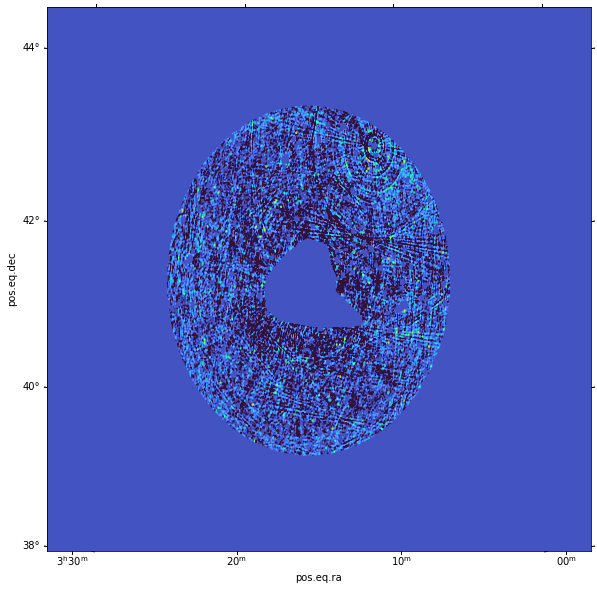

In [100]:
'''plot the residual image'''
fig, ax = plt.subplots( figsize=(12,10))
ax= plt.subplot(projection=WCS(wsrthdu[0].header)) 
ax.imshow(final_residual_wsrt_image, origin='lower', cmap='turbo', vmin=-0.001, vmax=0.01)

In [107]:
from photutils.background import Background2D, MeanBackground
from astropy.stats import SigmaClip
sigma_clip = SigmaClip(sigma=3.)
bkg_estimator = MeanBackground()
bkg = Background2D(final_residual_wsrt_image, (8, 8), filter_size=(3, 3), \
                   sigma_clip=sigma_clip, bkg_estimator=bkg_estimator)

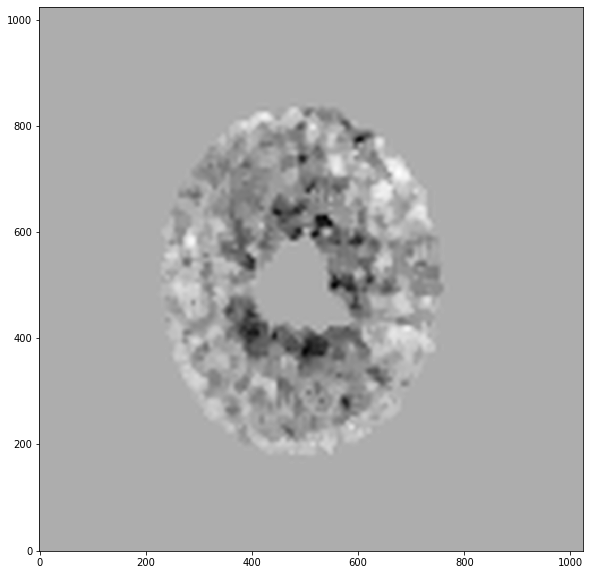

In [108]:
plt.figure( figsize=(12,10))
plt.imshow(bkg.background, origin='lower', cmap='Greys_r', interpolation='nearest')

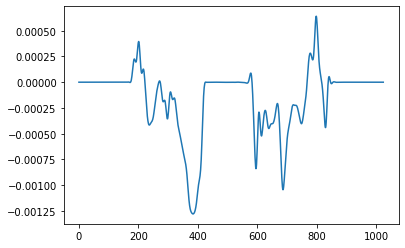

In [109]:
plt.plot(np.arange(1024), bkg.background[:, 512])

## Fit 

In [110]:
# Prepare fitting
x = np.arange(0, final_residual_wsrt_image.shape[1], 1)
y = np.arange(0, final_residual_wsrt_image.shape[0], 1)
xx, yy = np.meshgrid(x, y)

final_residual_mask_flat = final_residual_mask.ravel()
final_residual_wsrt_image_flat = bkg.background.ravel()[final_residual_mask_flat!=0]
x_f = xx.ravel()[final_residual_mask_flat!=0]
y_f = yy.ravel()[final_residual_mask_flat!=0]

In [111]:
x_f, y_f = x_f - 512, y_f - 512

In [112]:
# pred_params, uncert_cov = curve_fit(F, (xx.ravel(), yy.ravel()), final_residual_wsrt_image.ravel())
#                                         #p0=initial_guess, bounds=bounds)
pred_params, uncert_cov = curve_fit(F, (x_f, y_f), final_residual_wsrt_image_flat)
                                        #p0=initial_guess, bounds=bounds)

In [113]:
pred_params

array([  23.14052105,  159.85476508,    0.41855472, -170.97254352,
        151.97684992,    5.67419939, -170.09290614, -293.08719993,
         64.79805461,  336.32833486, -103.16762137, -313.08593414,
        101.30448738])

In [114]:
x_b, y_b = xx.ravel(),yy.ravel()
x_b, y_b = x_b - 512, y_b - 512

In [115]:
bowl = F((x_b, y_b), pred_params[0], pred_params[1], pred_params[2], pred_params[3], \
             pred_params[4], pred_params[5], pred_params[6], pred_params[7], \
             pred_params[8], pred_params[9], pred_params[10], pred_params[11], \
             pred_params[12])             

In [116]:
bowl_im = bowl.reshape(1024,1024)

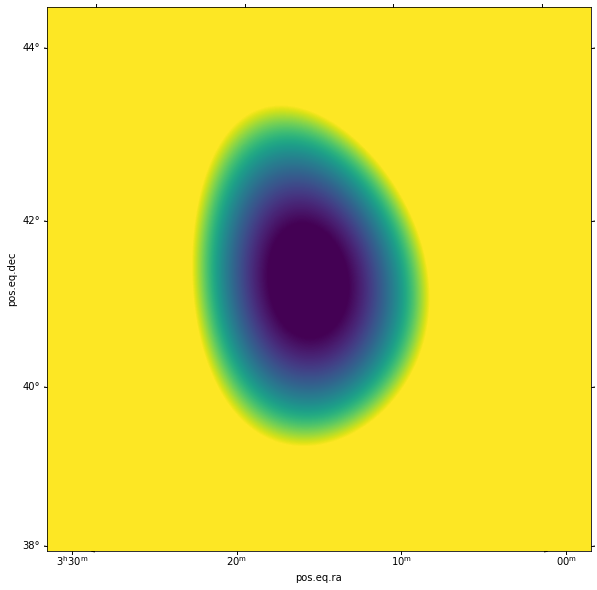

In [118]:
'''plot the bowl image'''
fig, ax = plt.subplots( figsize=(12,10))
ax= plt.subplot(projection=WCS(wsrthdu[0].header))
ax.imshow(bowl_im, origin='lower', cmap='viridis',vmin=-0.0005,vmax=0.00001)

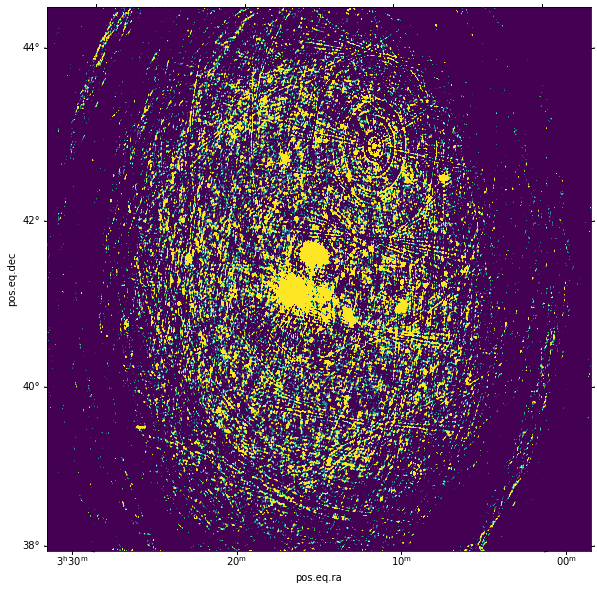

In [122]:
bowl_subtracted_data = wsrthdu[0].data - bowl_im

'''plot the bowl image'''
fig, ax = plt.subplots( figsize=(12,10))
ax= plt.subplot(projection=WCS(wsrthdu[0].header))
ax.imshow(bowl_subtracted_data, origin='lower', cmap='viridis', vmin=-0.00001, vmax=0.001)

## Plot residuals

In [123]:
bowl_masked = bowl_im*final_residual_mask

## residuals after removing the bowl
residuals = bkg.background*final_residual_mask - bowl_masked

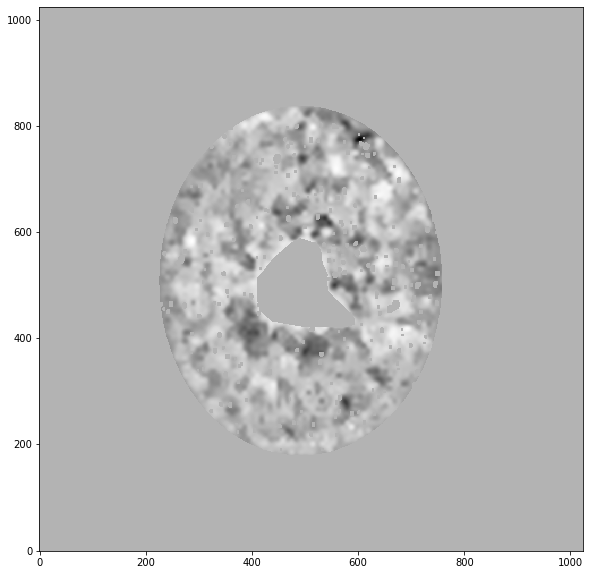

In [124]:
## plot residuals
plt.figure( figsize=(12,10))
plt.imshow(residuals, origin='lower', cmap='Greys_r', interpolation='nearest')

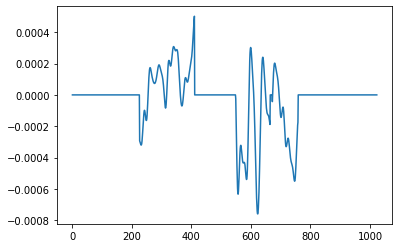

In [125]:
plt.plot(np.arange(1024), residuals[512,:])

In [126]:
#Save the lofar image matched to wsrt res and open it
ssp_wsrt = './wsrt_ssp_corrected_better.fits'
ssp_hdu = fits.PrimaryHDU (bowl_subtracted_data, header = wsrthdu[0].header)
ssp_hdu.writeto(ssp_wsrt)

In [58]:
#Save the lofar image matched to wsrt res and open it
ssp_wsrt = './wsrt_ssp_estimatedbowl.fits'
ssp_hdu = fits.PrimaryHDU (bowl_im, header = wsrthdu[0].header)
ssp_hdu.writeto(ssp_wsrt)